Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

# Deep Learning with Python

## 5.4 Visualizing what convnets learn

> Visualização de redes neurais convolucionais

Costumamos dizer que o aprendizado profundo é uma caixa preta e é difícil para nós extrair uma representação legível por humanos do processo de aprendizado. No entanto, este não é o caso das redes neurais convolucionais para visão computacional.As redes neurais convolucionais podem ser visualizadas, e podemos entendê-las, porque as redes neurais convolucionais são originalmente usadas para extrair "representações de conceitos visuais".

Existem muitas maneiras diferentes de visualizar redes neurais convolucionais de ângulos diferentes e explicar seu significado de forma razoável. Vários deles são apresentados a seguir.

### Visualizando ativações intermediárias

** Visualize a ativação intermediária **, que é a saída intermediária da rede neural convolucional visualizada. Essa visualização pode nos ajudar a entender como uma série de camadas convolucionais contínuas transformam e processam os dados de entrada e o significado básico de cada filtro.

Na verdade, isso é para exibir a saída dos mapas de feições pela camada de convolução / agrupamento (a saída da camada também pode ser chamada de ativação). O método específico é exibir os canais de saída como imagens bidimensionais.

Usamos um modelo gerado anteriormente como exemplo:

In [145]:
from tensorflow.keras.models import load_model

model = load_model('....dogs-vs-cats/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

Então, encontramos uma imagem que a rede não viu durante o treinamento：

In [160]:
img_path = '.../cats_and_dogs_small/test/cats/cat.1750.jpg'

from tensorflow.keras.preprocessing import image     #Transforme a imagem em um tensor 4D
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


Imagem de exibição:

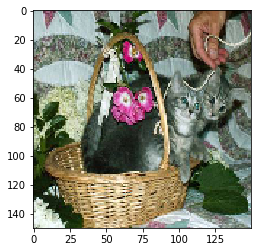

In [161]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

Para extrair o mapa de características, é necessário instanciar um modelo com um tensor de entrada e uma lista de tensores de saída:

In [162]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]    # Extraia a saída das primeiras 8 camadas
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Quando uma imagem é inserida, o modelo retornará os valores de ativação das primeiras 8 camadas do modelo original. Todos os nossos modelos anteriores fornecem uma entrada e retornam uma saída, mas, na verdade, um modelo pode fornecer qualquer número de entradas e retornar qualquer número de saídas.

Em seguida, insira a imagem que acabou de encontrar:

In [163]:
activations = activation_model.predict(img_tensor)
# Retorne uma lista de 8 matrizes Numpy, uma para cada camada, e ativação

In [164]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Essa coisa tem 32 canais, vamos apenas digitar um e ver:

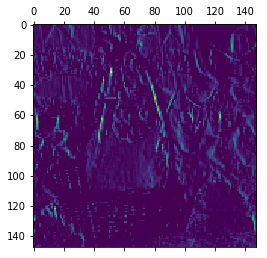

In [165]:
# Visualize o 4º canal

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

O que cada canal faz é basicamente aleatório, e o meu é diferente do livro.

A seguir, vamos desenhar uma visualização completa de todas as ativações em toda a rede. Desenhamos 8 mapas de recursos e todos os canais em cada um deles e os organizamos em uma imagem grande:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


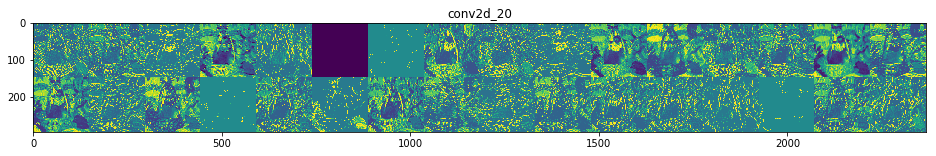

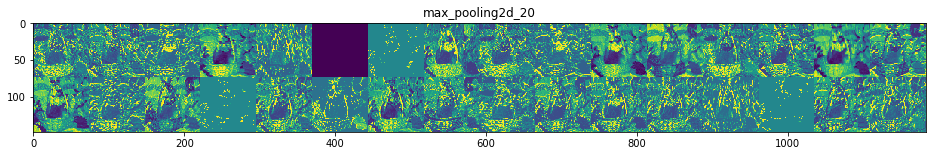

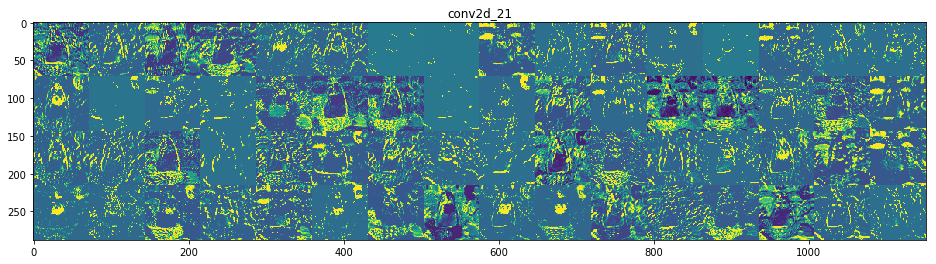

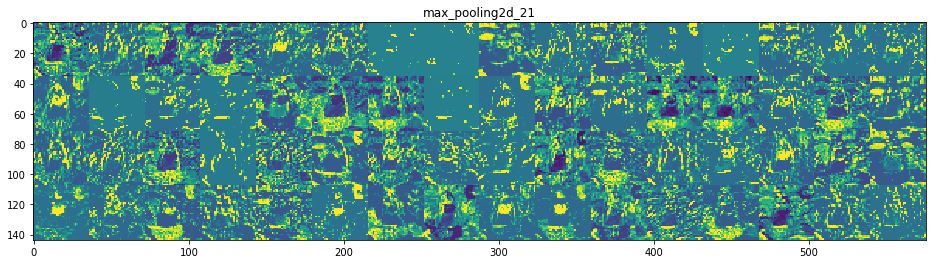

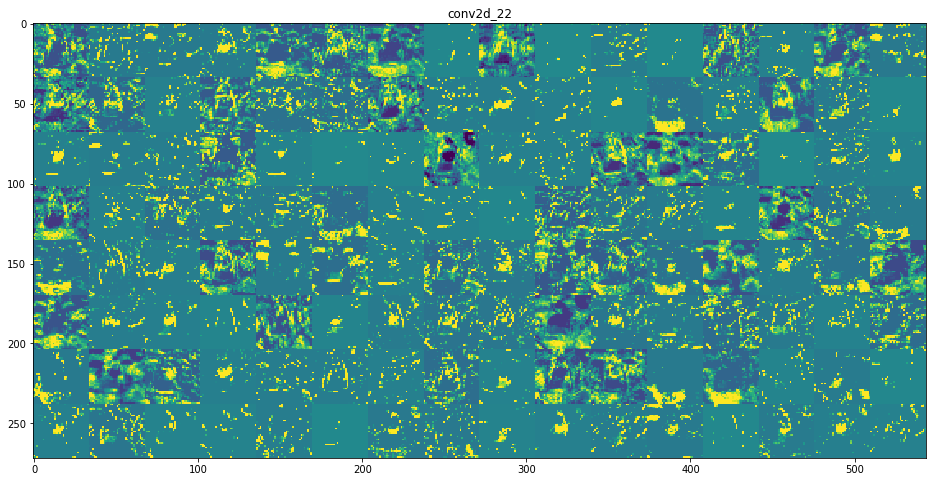

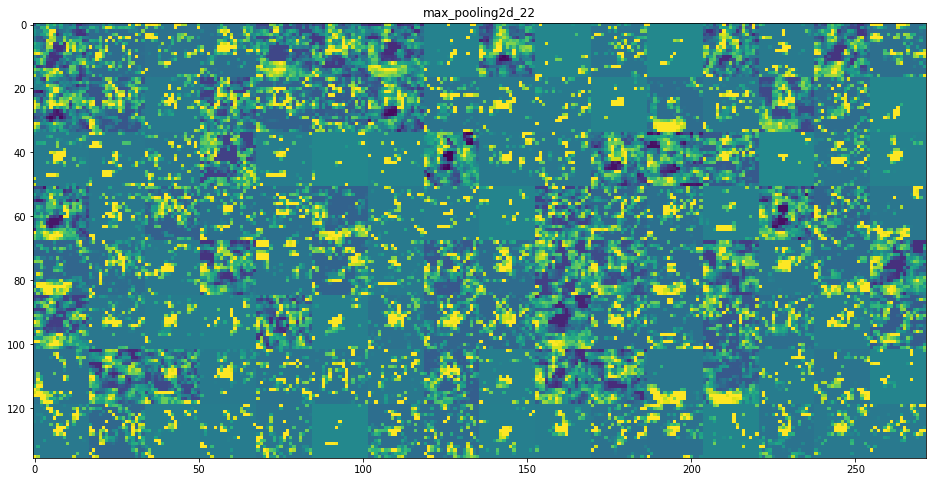

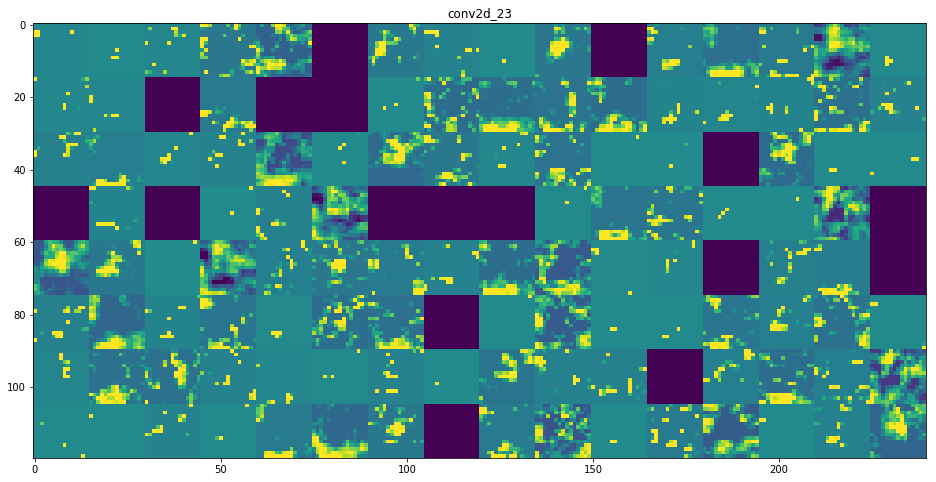

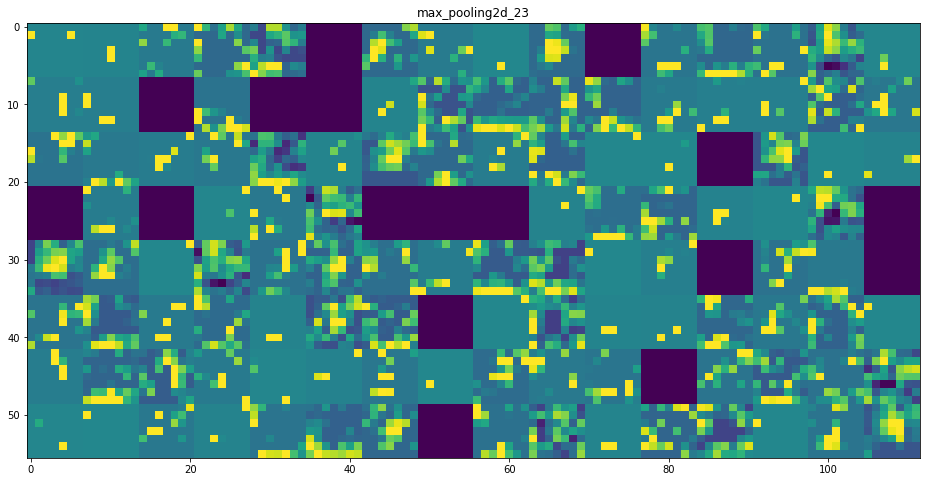

In [166]:
# Visualize todos os canais ativados em cada meio

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    # Para cada layer_activation, sua forma é (1, size, size, n_features)
    n_features = layer_activation.shape[-1]    # O número de recursos (canais) no mapa de recursos
    
    size = layer_activation.shape[1]   # Tamanho do figurino
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))     # Divisão
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            # Faça a imagem parecer melhor
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                        scale * display_grid.shape[0]))

    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


Percebe-se que as características estão se tornando cada vez mais abstratas. Ao mesmo tempo, há mais e mais pretos (cada vez mais esparsos) e os padrões codificados por esses filtros não podem ser encontrados na imagem de entrada, portanto, estão em branco.

Um importante recurso universal é mostrado aqui: conforme o número de camadas aumenta, os recursos extraídos pelas camadas tornam-se cada vez mais abstratos. As ativações de nível superior contêm cada vez menos informações sobre entradas específicas e cada vez mais informações sobre os alvos.

É semelhante à forma como os humanos e os animais percebem o mundo: após alguns segundos observando uma cena, os humanos podem lembrar quais objetos abstratos (como bicicletas e árvores) estão nela, mas não podem lembrar a aparência específica desses objetos. Seu cérebro irá abstrair automaticamente a entrada visual, isto é, convertê-la em conceitos visuais de nível superior, enquanto filtra detalhes visuais irrelevantes.

A rede neural profunda usa um canal de destilação de informações para inserir os dados originais (neste caso, uma imagem RGB), transformar repetidamente, filtrar informações irrelevantes (como a aparência específica da imagem) e ampliar e refinar os dados úteis Informações (como a categoria da imagem) e, finalmente, conclua o uso das informações (como determinar se a imagem é um gato ou um cachorro).

### Visualizando filtros de convnets

Visualizar os filtros da rede neural convolucional ajuda a entender que tipo de padrões visuais cada filtro aceita bem (padrão, acho que a palavra "padrão" não é uma boa interpretação do significado de padrão) ou conceito.

Para observar os filtros aprendidos pela rede neural convolucional, podemos exibir o padrão visual ao qual cada filtro responde. Isso pode ser alcançado com a subida de gradiente no espaço de entrada:

Para começar com uma imagem de entrada em branco e maximizar a resposta de um determinado filtro, a descida gradiente pode ser aplicada ao valor da imagem de entrada da rede neural convolucional. A imagem de entrada resultante é a imagem com maior resposta ao filtro.

Isso é muito simples de fazer: construir uma função de perda cujo objetivo é maximizar o valor de um determinado filtro de uma determinada camada convolucional. Em seguida, use a descida gradiente estocástica para ajustar o valor da imagem de entrada para maximizar seu valor de ativação.

Por exemplo, a perda de ativação do 0º filtro da camada block3_conv1 da rede VGG16 pré-treinada no ImageNet é:

In [199]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

print(loss)

Tensor("Mean_11:0", shape=(), dtype=float32)


Precisamos fazer a descida do gradiente, portanto, precisamos obter o gradiente de perda em relação à entrada do modelo. Use a função de gradientes de back-end de Keras para fazer isso:

In [200]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # See https://github.com/tensorflow/tensorflow/issues/33135

grads = K.gradients(loss, model.input)[0]
# Isso retorna uma lista contendo uma série de tensores. Aqui, o comprimento da lista é 1, então tomar [0] é um tensor
print(grads)

Tensor("gradients_1/block1_conv1_4/Conv2D_grad/Conv2DBackpropInput:0", shape=(None, None, None, 3), dtype=float32)


Aqui você pode usar um pequeno truque para fazer o processo de descida do gradiente suavemente: divida o tensor de gradiente por sua norma L2 (a raiz quadrada da média do quadrado do tensor) para normalizar. Esta operação pode manter o tamanho atualizado da imagem de entrada sempre no mesmo intervalo:

In [201]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)    # + 1e-5 Impedir divisão por 0
print(grads)

Tensor("truediv_1:0", shape=(None, None, None, 3), dtype=float32)


O problema que precisa ser abordado agora é que dada a imagem de entrada, calcule os valores de perda e grads. Isso pode ser feito com a função iterar: ela converte um tensor Numpy em uma lista de dois tensores Numpy, os dois tensores são o valor da perda e o valor do gradiente:

In [207]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
print(loss_value, grads_value)

0.0 [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


Então, vamos escrever a descida do gradiente:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


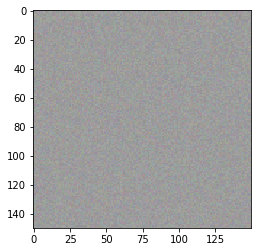

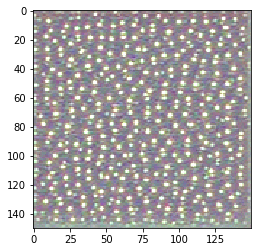

In [217]:
# Maximize a perda através da descida do gradiente estocástico

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.   # Qualquer imagem cinza com pontos secos

plt.imshow(input_img_data[0, :, :, :] / 225.)
plt.figure()

step = 1.    # Gradient update step size
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step    # Ajuste a imagem de entrada na direção que maximize a perda
    
plt.imshow(input_img_data[0, :, :, :] / 225.)
plt.show()

In [221]:
# Função de utilidade para converter tensor em imagem válida

def deprocess_image(x):
    # Padronizado, com média de 0 e desvio padrão de 0,1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # Recortar para [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # Converter x em matriz RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Junte todas as coisas acima para obter uma função completa para gerar a visualização do filtro:

In [227]:
# Função para gerar visualização de filtro

import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # See https://github.com/tensorflow/tensorflow/issues/33135

def generate_pattern(layer_name, filter_index, size=150):
    # Construa uma função de perda para maximizar a ativação do filtro filter_index de layer_name
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # Calcule o gradiente da perda em relação à imagem de entrada e normalize o gradiente
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Retorna a perda e gradiente da imagem de entrada fornecida
    iterate = K.function([model.input], [loss, grads])
    
    # Começando com uma imagem em tons de cinza barulhenta, o gradiente aumenta 40 vezes
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    # Resultado de saída
    img = input_img_data[0]
    return deprocess_image(img)

Então ele pode ser usado, ou o exemplo agora é o mesmo:

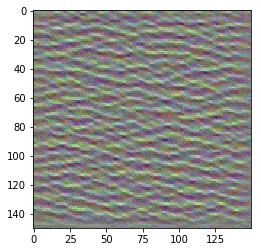

In [237]:
plt.imshow(generate_pattern('block3_conv1', 1))

Esta imagem é a resposta do 0º filtro na camada block3_conv1. Esse padrão é chamado de bolinhas (padrão de bolinhas).

Em seguida, visualizamos cada filtro em cada camada. Para sermos mais rápidos, visualizamos apenas os primeiros 64 filtros da primeira camada de cada bloco de convolução (a prevenção não faz sentido, basta dar uma olhada, fazer alguns deles):

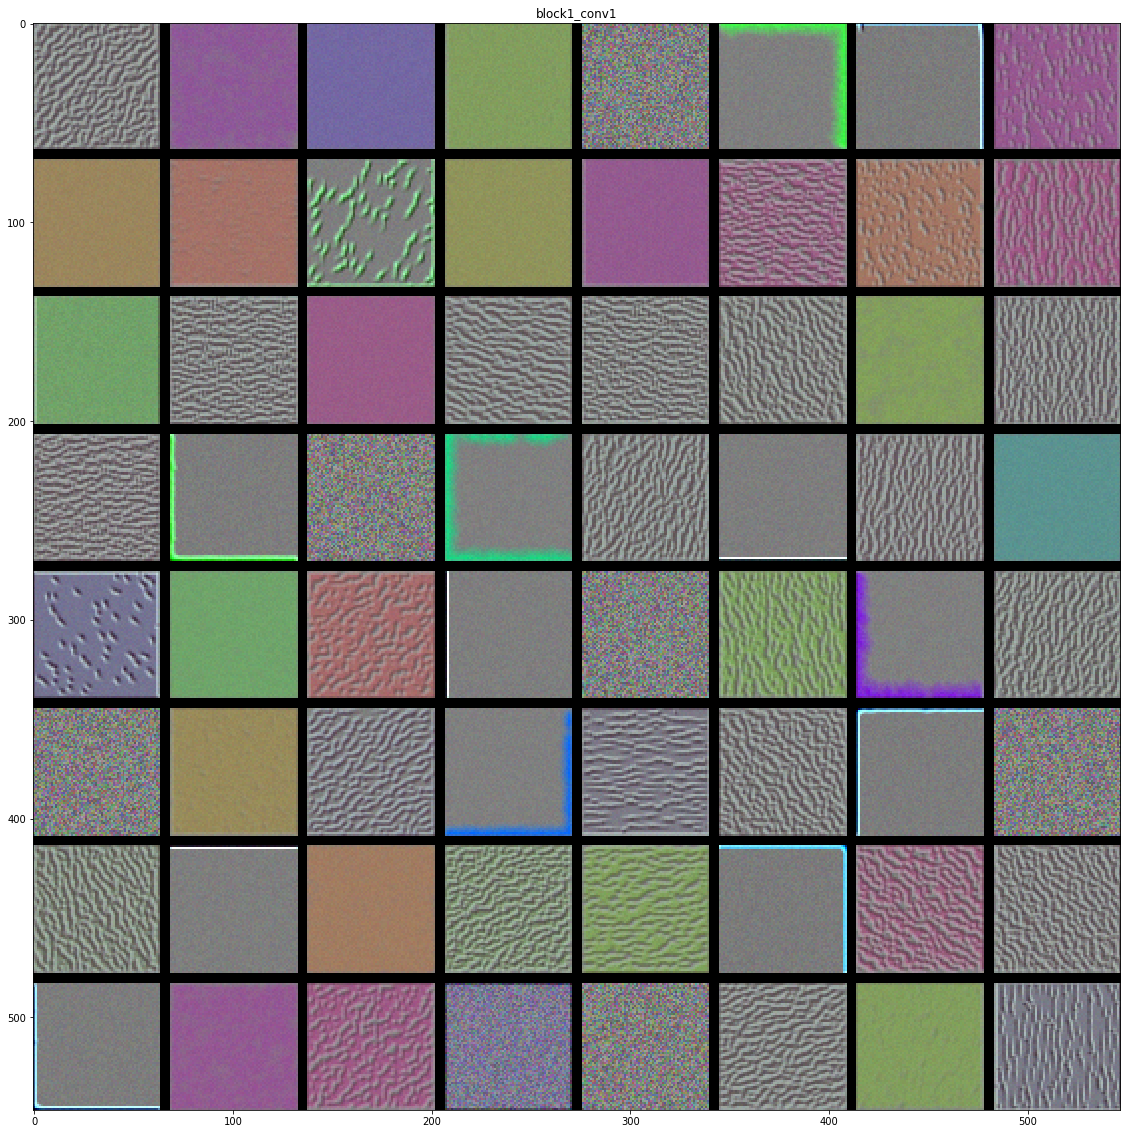

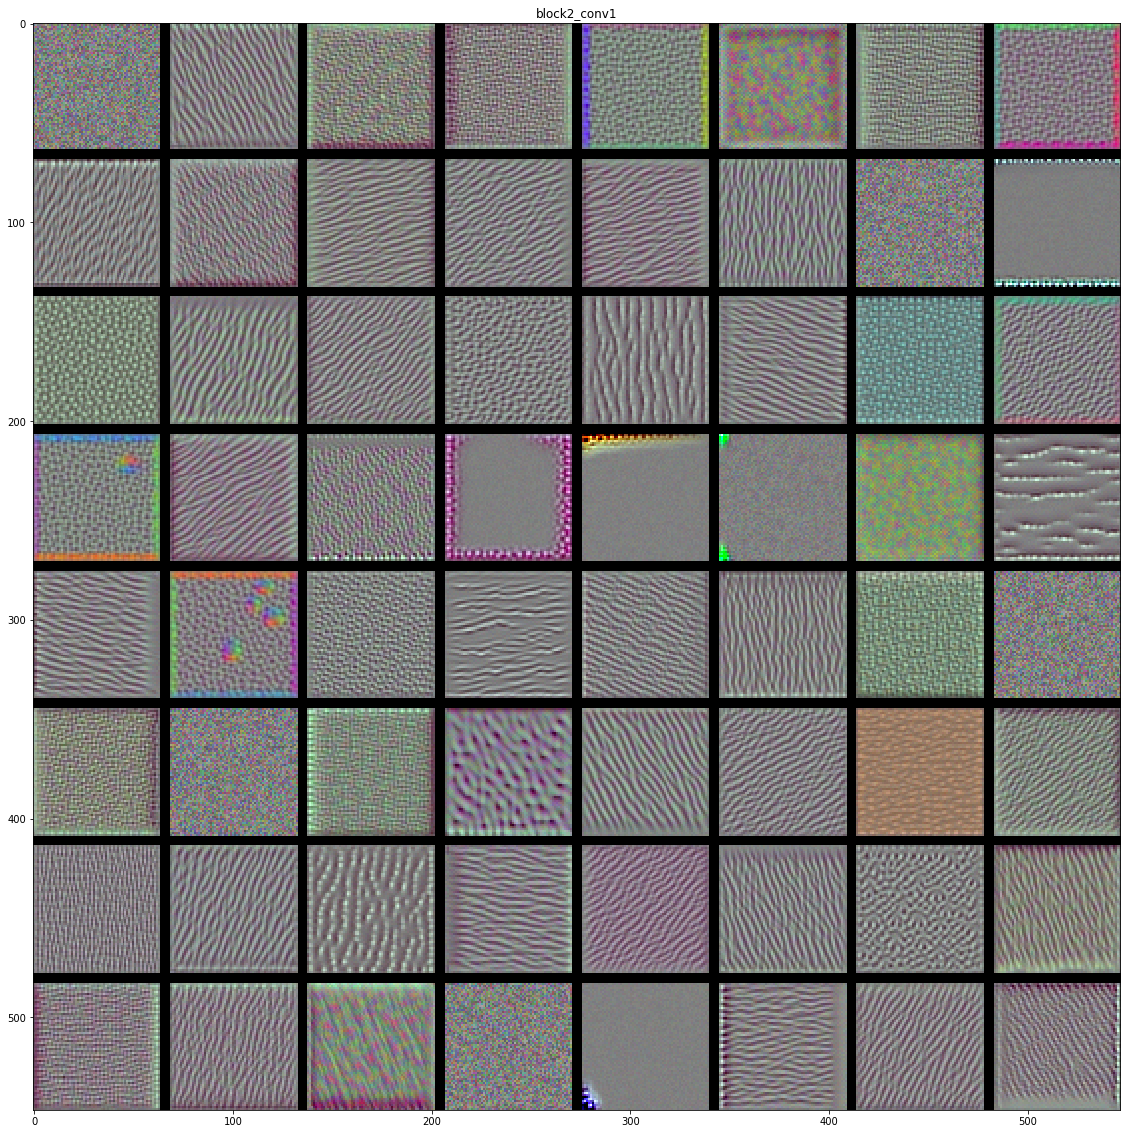

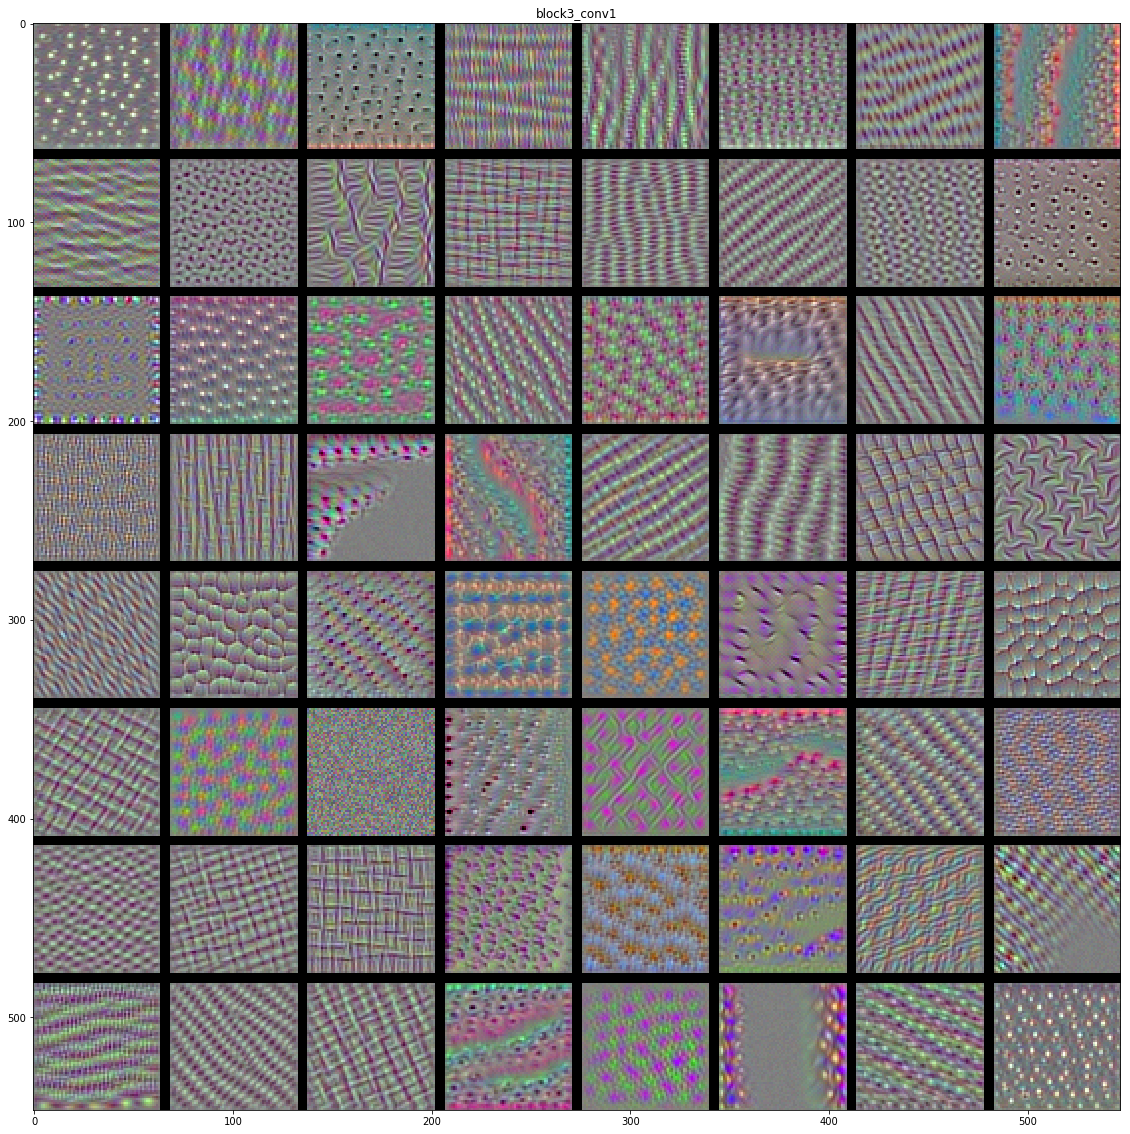

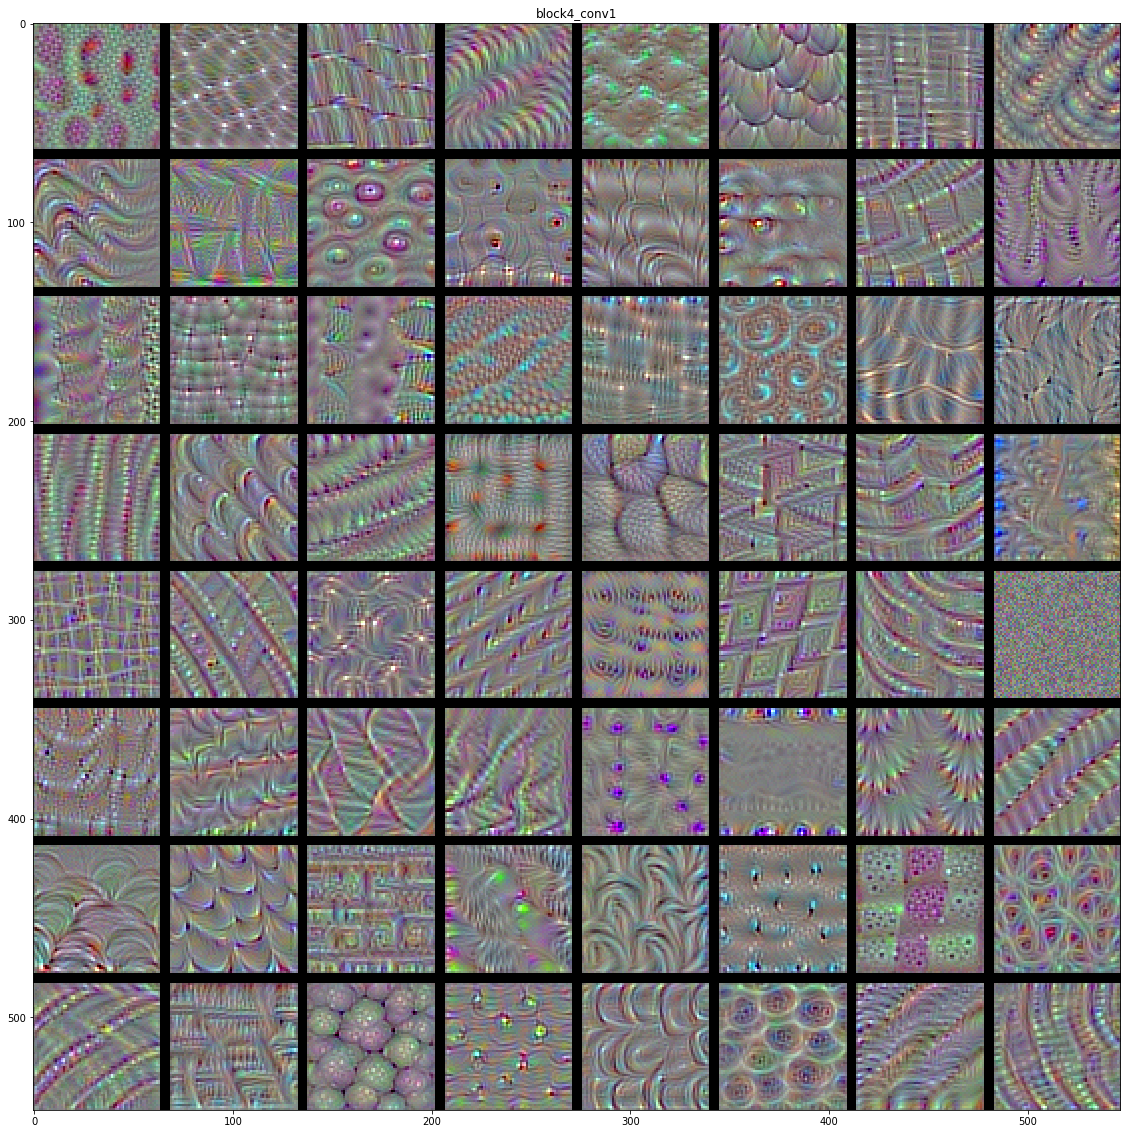

In [241]:
# Gere uma grade de todos os padrões de resposta do filtro em uma camada
def generate_patterns_in_layer(layer_name, size=64, margin=5):
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype=np.int)
    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            
            results[horizontal_start: horizontal_end,
                    vertical_start: vertical_end, :] = filter_img
            
    return results


layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
for layer in layer_names:
    img = generate_patterns_in_layer(layer)
    plt.figure(figsize=(20, 20))
    plt.title(layer)
    plt.imshow(img)

Essas imagens mostram como as camadas da rede neural convolucional observam as informações na imagem: cada camada na rede neural convolucional aprende um conjunto de filtros e, em seguida, a entrada será expressa como uma combinação de filtros, que na verdade é semelhante a O processo de transformação de Fourier. À medida que o número de camadas aumenta, os filtros na rede neural convolucional se tornam cada vez mais complexos e sofisticados, de modo que você pode extrair e "compreender" informações abstratas.

### Visualizando mapas de calor de ativação de classe em uma imagem

** O mapa de calor de ativação de classe em imagens visuais ** é usado para entender em qual parte da imagem a rede se baseia para identificar uma classe, e também ajuda a saber onde o objeto está na imagem.

Uma técnica usada para gerar mapas de calor de ativação de classe para imagens de entrada é chamada de visualização CAM (mapa de ativação de classe). O mapa de calor de ativação de classe calcula cada posição de qualquer imagem de entrada e mostra o quão importante cada posição é para a categoria. Por exemplo, em nossa rede de classificação de cães e gatos, podemos gerar um mapa de calor de ativação de classe para a imagem de um gato e podemos obter como diferentes partes da imagem são como gatos (é muito grande para o modelo pensar que é uma imagem de gato).

Especificamente, usamos [Grad-CAM] (https://arxiv.org/abs/ 1610.02391.) Este método: Dada uma imagem de entrada, para o mapa de feições de saída de uma camada convolucional, use a categoria relativa ao canal O gradiente de é ponderado para cada canal neste mapa de recursos. Falar de pessoas é usar a "importância de cada canal para a classificação" para ponderar o mapa espacial do "grau de ativação da imagem de entrada para diferentes canais" para obter o mapa espacial da "força de ativação da imagem de entrada para a categoria". (Emmm, esse tipo de frase super longa é melhor ler o texto original😭: Intuitivamente, uma maneira de entender esse truque é que você está ponderando um mapa espacial de “quão intensamente a imagem de entrada ativa diferentes canais” por “quão importante cada canal é com relação à classe ”, resultando em um mapa espacial de“ quão intensamente a imagem de entrada ativa a classe. ”)

Vamos demonstrar esse método no modelo VGG16:

In [16]:
# Carregue a rede VGG16 com pesos pré-treinados

from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')     # Observe que este possui um classificador, que é relativamente grande e lento para baixar (500 + MB)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Em seguida, tiramos uma foto para teste:

![creative_commons_elephant](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh83vzik31j30oz0goq7t.jpg)

Estes são dois elefantes asiáticos 🐘 Oh, processe esta imagem no que o modelo VGG16 precisa

In [8]:
!pwd

/Users/c/pylab/Deep Learning with Python/ch5


In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Preveja o que está na imagem：

In [19]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


É 90% certo que se trata de um elefante asiático, o que não é ruim. A próxima etapa é usar o algoritmo Grad-CAM para mostrar quais partes da imagem mais se parecem com elefantes africanos.

In [20]:
from tensorflow.keras import backend as K

import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # See https://github.com/tensorflow/tensorflow/issues/33135

african_elephant_output = model.output[:, 386]     # Este é o elemento que representa "Elefante africano" no vetor de saída

last_conv_layer = model.get_layer('block5_conv3')  # Mapa de recursos de saída VGG16 da última camada convolucional

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))    # O tamanho médio do gradiente do canal do mapa de recurso específico, a forma é (512,)

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])     # Calcule o gradiente e o mapa de recursos para o teste 🐘 imagem agora

for i in range(512):
   # Multiplique cada canal da matriz do mapa de recursos por "quão importante é este canal para a categoria" elefante ""
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)  # A média canal a canal do mapa de recursos processado é o mapa de calor de ativação de classe

Desenhe e veja:

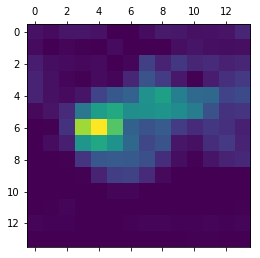

In [22]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

então usamos OpenCV para sobrepor isso na imagem original para ver:

In [24]:
import cv2

img = cv2.imread(img_path)    # Carregar imagem original
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))    # Ajuste o tamanho do mapa de calor para caber na imagem original
heatmap = np.uint8(255 * heatmap)    # Converter para o formato RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img    # Sobreposição
cv2.imwrite('./elephant_cam.jpg', superimposed_img)   # Salve

True

A imagem resultante é a seguinte:

![叠加到原图的热力图](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh84yvepspj30oz0go7a9.jpg)

Pode-se ver que a rede VGG16 realmente identificou apenas o pequeno elefante. Observe que a intensidade de ativação da cabeça do elefante bebê é muito forte. Esta pode ser a singularidade do elefante africano encontrado na rede.